In [1]:
#!pip install qulacs
#!pip install qulacsvis
#!pip install matplotlib
#!pip install numpy
#!pip install scipy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qulacs import Observable, QuantumState, PauliOperator, QuantumCircuit, ParametricQuantumCircuit, DensityMatrix
from qulacs.gate import  Identity,X, Y, H, Z, S, Sdag, DepolarizingNoise, DephasingNoise, AmplitudeDampingNoise, TwoQubitDepolarizingNoise

# 擬確率法を実装してみる

## エラーなしの場合

１次元横磁場イジング模型（４サイト）の基底状態をVQEで求める。解く対象は外挿法のものと共通。
\begin{align}
H=\sum_{i}(JZ_iZ_{i+1}+hX_i)
\end{align}

In [3]:
#１次元横磁場イジング模型のハミルトニアンを定義
n_qubits = 4
transverse_Ising_hamiltonian = Observable(n_qubits)
J = -1.0
h = -1.0
for i in range(n_qubits):
    transverse_Ising_hamiltonian.add_operator(J, f"Z {i} Z {(i+1)%n_qubits}")
    transverse_Ising_hamiltonian.add_operator(h, f"X {i}")

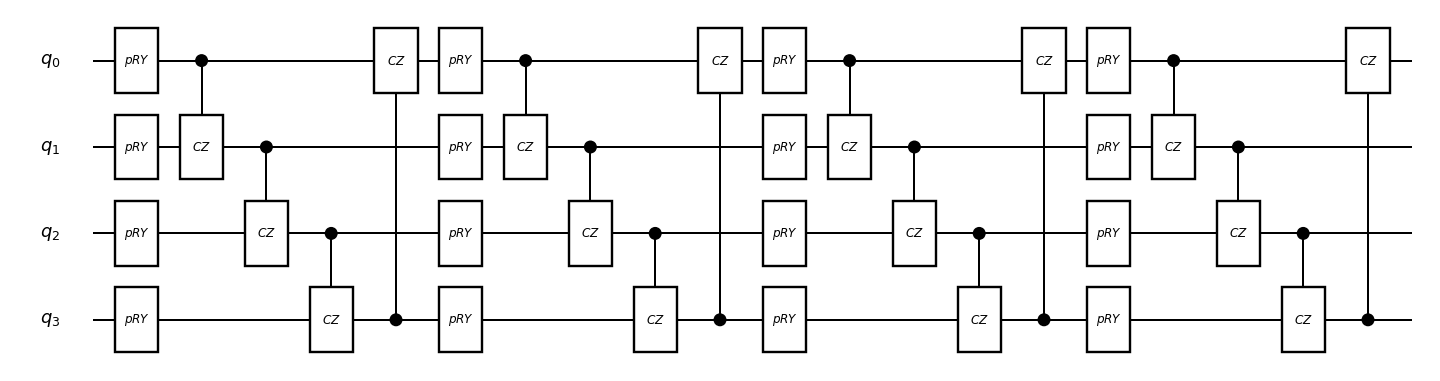

In [4]:
## まずはエラーなしの場合
from qulacsvis import circuit_drawer
from scipy.optimize import minimize

#状態ベクトル、ansatz回路を定義
n_qubits = 4
state = QuantumState(n_qubits)
circuit_depth = 4
circuit = ParametricQuantumCircuit(n_qubits)

#ansatz回路を指定
def Circuit(n_qubits,circuit_depth):
    circuit = ParametricQuantumCircuit(n_qubits)
    for d in range(circuit_depth):
        for i in range(n_qubits):
            circuit.add_parametric_RY_gate(i, 0.0)
        for i in range(n_qubits):
            circuit.add_CZ_gate(i, (i+1)%n_qubits)
    return circuit
circuit = Circuit(n_qubits,circuit_depth)
params = np.zeros(circuit.get_parameter_count())

#ansatz回路を表示
circuit_drawer(circuit, "mpl")

In [5]:
#コスト関数を定義。ここではエネルギー期待値がコスト関数。
def get_cost(params):
    state = QuantumState(n_qubits)
    for i, p in enumerate(params):
        circuit.set_parameter(i,p)
    circuit.update_quantum_state(state)
    return transverse_Ising_hamiltonian.get_expectation_value(state)

In [6]:
#上で定義したansatz回路のもとで、コスト関数を最小化する。
params_initial = np.zeros_like(params)
minimized_costfunction = minimize(get_cost, params_initial, options={'maxiter':50, "gtol": 1e-6}, method='BFGS')

#コスト関数の最小値を表示
print(minimized_costfunction.fun)

-5.072893485824641


In [7]:
params_true = minimized_costfunction.x

## エラーありの場合

各ゲートに以下のエラーを作用させます。

Depolarizing noise: $\mathcal{E}[\rho]=(1-p)\rho+\frac{p}{3} (X\rho X+Y\rho Y+Z\rho Z)$

In [8]:
## 次にdepolarizing noiseありの場合（１次元横磁場イジング模型）

#密度演算子、ansatz回路を定義
density_state = DensityMatrix(n_qubits)
noisy_circuit = ParametricQuantumCircuit(n_qubits)
error_rate = 0.01

#ansatz回路を指定
def NoisyCircuit(error_rate):
    noisy_circuit = ParametricQuantumCircuit(n_qubits)
    for d in range(circuit_depth):
        for i in range(n_qubits):
            noisy_circuit.add_parametric_RY_gate(i, 0.0)
            noisy_circuit.add_gate(DepolarizingNoise(i, error_rate))
        for i in range(n_qubits):
            noisy_circuit.add_CZ_gate(i, (i+1)%n_qubits)
            noisy_circuit.add_gate(DepolarizingNoise(i, error_rate))
            noisy_circuit.add_gate(DepolarizingNoise((i+1)%n_qubits, error_rate))
    return noisy_circuit

noisy_circuit = NoisyCircuit(error_rate)

In [9]:
#コスト関数を定義。ここではエネルギー期待値がコスト関数。
def noisy_get_cost(params):
    density_state = DensityMatrix(n_qubits)
    for i, p in enumerate(params):
        noisy_circuit.set_parameter(i,p)
    noisy_circuit.update_quantum_state(density_state)
    return transverse_Ising_hamiltonian.get_expectation_value(density_state)

In [10]:
#エラーなし、エラーありの場合で期待値を計算
minimized_costfunction_noiseless = get_cost(params_true)
minimized_costfunction_noise = noisy_get_cost(params_true)

#コスト関数の最小値を表示
print(minimized_costfunction_noiseless)
print(minimized_costfunction_noise)

-5.072893485824641
-3.8479645272663956


In [11]:
def get_cost_sampling(shots,params):
    density_state = DensityMatrix(n_qubits)
    noisy_circuit = NoisyCircuit(error_rate)
    for i, p in enumerate(params):
        noisy_circuit.set_parameter(i,p)
    noisy_circuit.update_quantum_state(density_state)
    density_copy_ZZ = DensityMatrix(n_qubits)
    density_copy_X = DensityMatrix(n_qubits)
    density_copy_ZZ = density_state.copy()
    density_copy_X = density_state.copy()
    mask_list_ZZ = [0b1100,0b0110,0b0011,0b1001]
    mask_list_X = [0b1000,0b0100,0b0010,0b0001]   
    for i in range(n_qubits):
        gate = H(i)
        gate.update_quantum_state(density_copy_X)
    noise_sampling_ZZ = density_copy_ZZ.sampling(shots)
    noise_sampling_X = density_copy_X.sampling(shots)
    estimated_ZZ_average = 0.0
    estimated_X_average = 0.0
    for s in noise_sampling_ZZ:
        for mask in mask_list_ZZ:
            bitcount = bin(s & mask).count("1")
            estimated_ZZ_average += (-1)**bitcount/shots
    for s in noise_sampling_X:
        for mask in mask_list_X:
            bitcount = bin(s & mask).count("1")
            estimated_X_average += (-1)**bitcount/shots
    data_sampling_average = h * estimated_X_average + J * estimated_ZZ_average
    return data_sampling_average

In [12]:
#エラー率を固定して、ヒストグラムを作成
error_rate = 0.01
n_test = 300
shots = 1000
no_mitigation_list = np.zeros(n_test)

for i in range(n_test):
    density_state = DensityMatrix(n_qubits)
    noisy_circuit = NoisyCircuit(error_rate)
    no_mitigation_list[i] = get_cost_sampling(shots,params_true)
expec_value = noisy_get_cost(params_true)

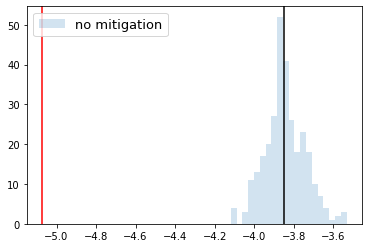

In [23]:
plt.hist(no_mitigation_list, alpha=0.2, bins=20, label=f"no mitigation")
plt.axvline(expec_value, color="black")
plt.axvline(get_cost(params_true), color="red")
plt.legend(loc="upper left", fontsize=13)
plt.show()

## 擬確率法

擬確率法を実装して、エラーを抑制する。

エラーの逆写像は以下の通り。

$\mathcal{E}^{-1}[\rho]=\frac{3-p}{3-4p}\rho-\frac{p}{3-4p} (X\rho X+Y\rho Y+Z\rho Z)$

この逆写像そのものは量子回路上で実装できないので、確率的に実装する。

In [14]:
#逆写像を確率的に実装するゲートを定義
#パリティの値も取得する。恒等演算子のときは＋１、それ以外だと－１にする。
import random
def recovery_gate_depolarizing(i,error_rate):
    ran = random.uniform(0, 1)
    q1 = (3.0-error_rate)/(3.0-4.0*error_rate)
    q2 = error_rate/(3.0-4.0*error_rate)
    p1 = q1/(q1+3.0*q2)
    p2 = (q1+q2)/(q1+3.0*q2)
    p3 = (q1+2.0*q2)/(q1+3.0*q2)
    if 0 < ran < p1:
        gate = Identity(i)
        parity = 1.0
    elif p1 < ran < p2:
        gate = X(i)
        parity = -1.0
    elif p2 < ran < p3:
        gate = Y(i)
        parity = -1.0
    elif p3 < ran < 1.0:
        gate = Z(i)
        parity = -1.0
    outcome = [gate,parity]
    return outcome

In [15]:
#上で定義した確率的なゲートを脱分極エラーの直後に挿入
def NoisyCircuit_recovery(error_rate):
    noisy_circuit_PEC = ParametricQuantumCircuit(n_qubits)
    parity_total = 1.0
    for d in range(circuit_depth):
        for i in range(n_qubits):
            noisy_circuit_PEC.add_parametric_RY_gate(i, 0.0)
            noisy_circuit_PEC.add_gate(DepolarizingNoise(i, error_rate))
            gate_parity = recovery_gate_depolarizing(i,error_rate)
            noisy_circuit_PEC.add_gate(gate_parity[0])
            #ここで、各ゲートのパリティの合計を計算する
            parity_total = parity_total*gate_parity[1]
        for i in range(n_qubits):
            noisy_circuit_PEC.add_CZ_gate(i, (i+1)%n_qubits)
            noisy_circuit_PEC.add_gate(DepolarizingNoise(i, error_rate))
            gate_parity = recovery_gate_depolarizing(i,error_rate)
            noisy_circuit_PEC.add_gate(gate_parity[0])
            parity_total = parity_total*gate_parity[1]
            noisy_circuit_PEC.add_gate(DepolarizingNoise((i+1)%n_qubits, error_rate))
            gate_parity = recovery_gate_depolarizing((i+1)%n_qubits,error_rate)
            noisy_circuit_PEC.add_gate(gate_parity[0])
            #ここで、各ゲートのパリティの合計を計算する
            parity_total = parity_total*gate_parity[1]
    outcome = [noisy_circuit_PEC,parity_total]
    return outcome

noisy_circuit_PEC = NoisyCircuit_recovery(error_rate)[0]
parity_tot = NoisyCircuit_recovery(error_rate)[1]

In [16]:
#上で定義した回路からサンプリングする
def get_cost_sampling_PEC(shots,params):
    estimated_ZZ_average = 0.0
    estimated_X_average = 0.0
    for j in range(shots):
        state = QuantumState(n_qubits)
        outcome = NoisyCircuit_recovery(error_rate)
        cost = (3.0+2.0* error_rate)/(3.0-4.0*error_rate)
        noisy_circuit_PEC = outcome[0]
        for i, p in enumerate(params):
            noisy_circuit_PEC.set_parameter(i,p)
        noisy_circuit_PEC.update_quantum_state(state)
        state_copy_ZZ = QuantumState(n_qubits)
        state_copy_X = QuantumState(n_qubits)
        state_copy_ZZ = state.copy()
        state_copy_X = state.copy()
        mask_list_ZZ = [0b1100,0b0110,0b0011,0b1001]
        mask_list_X = [0b1000,0b0100,0b0010,0b0001]
        for i in range(n_qubits):
            gate = H(i)
            gate.update_quantum_state(state_copy_X)
        noise_sampling_ZZ = state_copy_ZZ.sampling(1)
        noise_sampling_X = state_copy_X.sampling(1)
        for s in noise_sampling_ZZ:
            for mask in mask_list_ZZ:
                bitcount = bin(s & mask).count("1")
                #outcome[1]はパリティの値。パリティの値を作用させる。
                estimated_ZZ_average += (-1)**bitcount/shots * outcome[1] 
        for s in noise_sampling_X:
            for mask in mask_list_X:
                bitcount = bin(s & mask).count("1")
                estimated_X_average += (-1)**bitcount/shots * outcome[1]
    #最後に測定結果を足し合わせる際に、全体にコストを掛ける。
    data_sampling_average = (h * estimated_X_average + J * estimated_ZZ_average) * cost**((3.0*n_qubits) * circuit_depth)
    return data_sampling_average

In [17]:
get_cost_sampling_PEC(shots,params_true)

-5.208917885503317

## ヒストグラムを作成（※計算時間が長い）

In [18]:
#エラー率を固定して、ヒストグラムを作成
error_rate = 0.01
n_test = 300
shots = 1000
PEC_list = np.zeros(n_test)

for i in range(n_test):
    state = QuantumState(n_qubits)
    noisy_circuit_PEC = ParametricQuantumCircuit(n_qubits)
    PEC_list[i] = get_cost_sampling_PEC(shots,params_true)

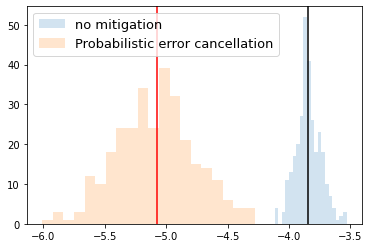

In [21]:
plt.hist(no_mitigation_list, alpha=0.2, bins=20, label=f"no mitigation")
plt.hist(PEC_list, alpha=0.2, bins=20, label=f"Probabilistic error cancellation")
plt.axvline(expec_value, color="black")
plt.axvline(get_cost(params_true), color="red")
plt.legend(loc="upper left", fontsize=13)
plt.show()

擬確率法により、確かにエラーが抑制できていることが分かります。

In [20]:
cost = (3.0+2.0* error_rate)/(3.0-4.0*error_rate)
cost**((3.0*n_qubits) * circuit_depth)

2.6201800228890098

コストは2.6程度で、上のヒストグラムの広がりの比とほぼ同じ値であることが分かります。